In [2]:
%reload_ext autoreload
%autoreload 2
%reload_ext notexbook
%texify

#### Imports

In [23]:
from tqdm.notebook import tqdm

import os
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import ncolor, edt
import numpy as np
from pathlib import Path
from numba import njit, float32, int32, vectorize
np.seterr(invalid="ignore")
%matplotlib qt

import time
import random
import matplotlib as mpl


# Data on which Omnipose networks are trained are in EXP-22-BP0394 data directory
DATASET_PATH = '../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/'
TRACKING_DATASET_PATH = '../../../data/EXP-22-BP0394 Analysis code data and models/data/tracking_data/'

# write the path of the omnipose model file here, it should be 
MODEL_CHECKPOINT_PATH = '../../saved_models/omnipose_mm_old_new_320_long.ckpt'
SAVE_DIR = '../../figures/main/'

#MODEL_CHECKPOINT_PATH = CHECKPOINT_PATH + "/MM_OMNI/lightning_logs/version_5/checkpoints/epoch=111-step=559.ckpt"

device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:1


In [4]:
from narsil2.segmentation.datasets import MMData, MMDataTest
from narsil2.segmentation.utils_omni import reconstruct_masks_cpu_omni, format_labels, clean_boundary
from narsil2.segmentation.transformations import OmniTestTransformations, unpadNumpyArray, OmniTransformations
from narsil2.segmentation.networks import Unet
from narsil2.segmentation.losses import OmniLoss
from narsil2.segmentation.lightning_modules import UTrainingModule
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from narsil2.segmentation.transformations import normalize99
from skimage import io


In [5]:

train_data = MMData(train=True, transforms=None,
                    dataset_path=DATASET_PATH, flows=True, saved_flows=True,
                    phase_fileformat='*.tif',
                   labels_fileformat="*.npy", mothermachine_data=True)
                   
print("Length of train data", len(train_data))

Length of train data 232


In [6]:
for i in range(len(train_data)):
    print(i, train_data[i]['filename'])

0 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000209_1.tif
1 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000154_1.tif
2 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000173_1.tif
3 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000161_1.tif
4 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000196_1.tif
5 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000127_1.tif
6 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000156_1.tif
7 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000214_1.tif
8 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000150_1.tif
9

74 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000012_1.tif
75 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000142_1.tif
76 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000129_1.tif
77 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000165_1.tif
78 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000020_2.tif
79 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000116_1.tif
80 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000037_2.tif
81 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000026_1.tif
82 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_00000023

147 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000048_1.tif
148 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000230_1.tif
149 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000043_1.tif
150 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000148_1.tif
151 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000000_1.tif
152 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000015_1.tif
153 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000012_2.tif
154 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000144_1.tif
155 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img

220 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000223_1.tif
221 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000245_1.tif
222 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000112_1.tif
223 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000191_1.tif
224 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000044_2.tif
225 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000123_1.tif
226 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000239_1.tif
227 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000178_1.tif
228 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img

In [7]:
from narsil2.segmentation.utils_omni import flows_to_colors, single_flow_to_color

#### Generate images for segmenation workflow 
#### Fig 2a

##### Plotting img_000000036_1 as it looks nice with different kinds of cells

In [8]:
sample = train_data[128]
print(f"Filename of the dataponit used to generate images:\n {sample['filename']}")
flowYX = sample['labels'][2:4]
flowY = sample['labels'][2]
flowX = sample['labels'][3]
mask = sample['labels'][6]


phase = sample['phase'][200:712, 1100: 1612]
flowY = sample['labels'][2][200:712, 1100: 1612]
flowX = sample['labels'][3][200:712, 1100: 1612]
mask = sample['labels'][6][200:712, 1100: 1612]
distance_field = sample['labels'][1][200:712, 1100: 1612]
boundary = sample['labels'][5][200:712, 1100: 1612]
labels = sample['labels'][0][200:712, 1100: 1612]

Filename of the dataponit used to generate images:
 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000037_1.tif


In [9]:
save_phase = SAVE_DIR + '/fig2/phase2a.svg'
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(phase, cmap='gray')
ax.set_axis_off()
fig.savefig(save_phase, bbox_inches='tight', pad_inches=0)
plt.close(fig)


save_flowY = SAVE_DIR + '/fig2/flowY2a.svg'
fig, ax = plt.subplots(nrows=1, ncols=1)
flowY_img = single_flow_to_color(flowY, mask, type='Y')
ax.imshow(flowY_img)
ax.set_axis_off()
fig.savefig(save_flowY, bbox_inches='tight', pad_inches=0)
plt.close(fig)

save_flowX = SAVE_DIR + '/fig2/flowX2a.svg'
fig, ax = plt.subplots(nrows=1, ncols=1)
flowX_img = single_flow_to_color(flowX, mask, type='X')
ax.imshow(flowX_img)
ax.set_axis_off()
fig.savefig(save_flowX, bbox_inches='tight', pad_inches=0)
plt.close(fig)

save_boundary = SAVE_DIR + '/fig2/boundary2a.svg'
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(boundary, cmap='Spectral')
ax.set_axis_off()
fig.savefig(save_boundary, bbox_inches='tight', pad_inches=0)
plt.close(fig)


save_distance_field = SAVE_DIR + '/fig2/distance2a.svg'
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(distance_field, cmap='turbo')
ax.set_axis_off()
fig.savefig(save_distance_field, bbox_inches='tight', pad_inches=0)
plt.close(fig)


def custom_cmap(cmap_str):
    # generates a cmap with white for the background
    cmap = plt.get_cmap(cmap_str)
    greys = plt.get_cmap('Greys', 20)
    cmap_list = [cmap(i) for i in range(cmap.N)]
    #random.shuffle(cmap_list)
    cmap_list = [greys(0)] + cmap_list
    custom_cmap = mpl.colors.LinearSegmentedColormap.from_list('custom_cmap', cmap_list, cmap.N + 1)
    return custom_cmap
    

save_labels = SAVE_DIR + '/fig2/labels2a.svg'
fig, ax = plt.subplots(nrows=1, ncols=1)
img = ax.imshow(labels, cmap=custom_cmap('viridis'), interpolation='nearest')
ax.set_axis_off()
fig.savefig(save_labels, bbox_inches='tight', pad_inches=0)
plt.close(fig)

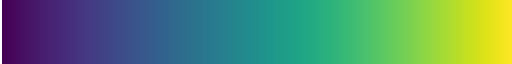

In [10]:
custom_cmap('viridis')

#### Metrics for comparing Omnipose with U-net
#### Fig 2b

##### Run these notebook first and extract the metrics from them

1. ../seg_notebooks/Metrics-Unet-MM Data.ipynb
2. ../seg_notebooks/Metrics- Omnipose-MM Data.ipynb OmniRes is a bad name. It is still a U-net arch that predicts 4 things instead of one thing

Copy metrics from these notebooks that are highlighted in them and plot them nicely

In [11]:
threshold = np.linspace(0.5, 1, 100)

In [12]:
metrics_only_mixed_unet = np.array([5.2288461e-01, 5.2068090e-01, 5.1858687e-01, 5.1672941e-01,
       5.1540202e-01, 5.1346755e-01, 5.1194388e-01, 5.1024640e-01,
       5.0959224e-01, 5.0868493e-01, 5.0771374e-01, 5.0730634e-01,
       5.0607902e-01, 5.0513774e-01, 5.0302607e-01, 5.0202250e-01,
       5.0112402e-01, 5.0046277e-01, 4.9962589e-01, 4.9855608e-01,
       4.9618116e-01, 4.9570736e-01, 4.9475265e-01, 4.9423116e-01,
       4.9299863e-01, 4.9202961e-01, 4.9090275e-01, 4.8991060e-01,
       4.8921254e-01, 4.8911577e-01, 4.8878056e-01, 4.8812020e-01,
       4.8741728e-01, 4.8647201e-01, 4.8510170e-01, 4.8453176e-01,
       4.8321950e-01, 4.8182929e-01, 4.8088753e-01, 4.7673717e-01,
       4.7457737e-01, 4.7343621e-01, 4.7257912e-01, 4.7193828e-01,
       4.6985981e-01, 4.6876591e-01, 4.6693203e-01, 4.6381107e-01,
       4.6175611e-01, 4.5970675e-01, 4.5802036e-01, 4.5571959e-01,
       4.5235905e-01, 4.4668263e-01, 4.4289562e-01, 4.3890259e-01,
       4.3400201e-01, 4.3109876e-01, 4.2653126e-01, 4.2169762e-01,
       4.1681838e-01, 4.0672925e-01, 3.9795712e-01, 3.8736984e-01,
       3.7705666e-01, 3.6672688e-01, 3.5614827e-01, 3.3762243e-01,
       3.1910616e-01, 3.0079806e-01, 2.8038365e-01, 2.6043004e-01,
       2.3283353e-01, 2.0559709e-01, 1.8206233e-01, 1.5499112e-01,
       1.3112368e-01, 1.0652599e-01, 8.7873794e-02, 7.1041606e-02,
       5.2920137e-02, 3.8193792e-02, 2.7532693e-02, 1.8327355e-02,
       1.1181131e-02, 6.7662159e-03, 3.6521319e-03, 1.6192833e-03,
       6.7354477e-04, 1.7454584e-04, 3.2870947e-05, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
      dtype=np.float32)

In [13]:
metrics_only_mixed_omnipose = np.array([7.97724068e-01, 7.92854846e-01, 7.88897097e-01, 7.86378622e-01,
       7.84835339e-01, 7.83622026e-01, 7.81888425e-01, 7.80597806e-01,
       7.78956532e-01, 7.78510392e-01, 7.76897311e-01, 7.74958849e-01,
       7.74550855e-01, 7.74224460e-01, 7.72433519e-01, 7.71075726e-01,
       7.70289302e-01, 7.69279361e-01, 7.68176138e-01, 7.67558277e-01,
       7.67127872e-01, 7.66250372e-01, 7.63657153e-01, 7.63341367e-01,
       7.62273729e-01, 7.60519326e-01, 7.59869456e-01, 7.58775175e-01,
       7.58149743e-01, 7.57224798e-01, 7.55478323e-01, 7.55267143e-01,
       7.54255652e-01, 7.52880275e-01, 7.52153575e-01, 7.50733376e-01,
       7.50240445e-01, 7.49680936e-01, 7.48218358e-01, 7.46006668e-01,
       7.45545387e-01, 7.44204938e-01, 7.43796945e-01, 7.42194414e-01,
       7.41666257e-01, 7.39501178e-01, 7.38545835e-01, 7.36005962e-01,
       7.34529197e-01, 7.33008027e-01, 7.31101930e-01, 7.29328036e-01,
       7.26961613e-01, 7.24249423e-01, 7.22235024e-01, 7.19500661e-01,
       7.18100250e-01, 7.15892851e-01, 7.10560858e-01, 7.02046394e-01,
       6.97607577e-01, 6.90566242e-01, 6.84907138e-01, 6.77030385e-01,
       6.67105138e-01, 6.55756652e-01, 6.42387033e-01, 6.24386966e-01,
       6.05724394e-01, 5.82218766e-01, 5.59218407e-01, 5.32602608e-01,
       5.01531839e-01, 4.70987260e-01, 4.31569219e-01, 3.93058598e-01,
       3.51521850e-01, 3.11727166e-01, 2.70794839e-01, 2.28814960e-01,
       1.88821614e-01, 1.48578301e-01, 1.18594766e-01, 9.16354060e-02,
       6.33170679e-02, 4.26181369e-02, 2.77536493e-02, 1.54546527e-02,
       8.82746931e-03, 5.95051702e-03, 2.79201404e-03, 1.40552339e-03,
       9.51599155e-04, 4.77240479e-04, 2.17770052e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
      dtype=np.float32)

###### Plotting two curves

In [14]:
labelsize=12
axcol='k'
background_color='k'
#plt.style.use('dark_background')
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.xticks(np.arange(min(threshold), max(threshold)+1, 0.25))
plt.xlim([0.5, 1])
plt.ylim([0, 1])
ax.plot(threshold, metrics_only_mixed_omnipose, color='r',linewidth=2, label='Omnipose')
ax.plot(threshold, metrics_only_mixed_unet, color='b',linewidth=2, label='U-net')

ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True)
ax.set_ylabel('Jaccard Index', fontsize=labelsize)
ax.set_xlabel('IoU matching threshold', fontsize=labelsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.patch.set_alpha(0.0)
#fig.patch.set_facecolor(background_color)
ax.legend()
plt.show()

save_metrics = SAVE_DIR + '/fig2/metrics2b.svg'
fig.savefig(save_metrics)
plt.close(fig)

#### Comparing Images between different segmentations
#### Fig 2c

In [15]:
PHASE_DIR = Path(DATASET_PATH + "/phase_train")
MASKS_TRUE_DIR = Path(DATASET_PATH + "/masks_train")
MASKS_OMNI_DIR = Path(DATASET_PATH + "/metrics_omni_masks")
MASKS_UNET_DIR = Path(DATASET_PATH + "/metrics_unet_masks")
# collect filenames appropirately in two lists

PHASE_FILENAMES = sorted(list(PHASE_DIR.glob("*.tif")),
                              key=lambda x: int(x.stem.split("_")[1]))

PHASE_FILENAMES = sorted(PHASE_FILENAMES,
                              key=lambda x: int(x.stem.split("_")[2]))

MASKS_TRUE_FILENAMES = sorted(list(MASKS_TRUE_DIR.glob("*.tif")),
                              key=lambda x: int(x.stem.split("_")[1]))

MASKS_TRUE_FILENAMES = sorted(MASKS_TRUE_FILENAMES,
                              key=lambda x: int(x.stem.split("_")[2]))


MASKS_OMNI_FILENAMES = sorted(list(MASKS_OMNI_DIR.glob("*.png")),
                             key=lambda x: int(x.stem.split("_")[1]))


MASKS_OMNI_FILENAMES = sorted(MASKS_OMNI_FILENAMES,
                             key=lambda x: int(x.stem.split("_")[2]))



MASKS_UNET_FILENAMES = sorted(list(MASKS_UNET_DIR.glob("*.tif")),
                             key=lambda x: int(x.stem.split("_")[1]))


MASKS_UNET_FILENAMES = sorted(MASKS_UNET_FILENAMES,
                             key=lambda x: int(x.stem.split("_")[2]))

In [16]:
for i in range(len(PHASE_FILENAMES)):
    print(i, PHASE_FILENAMES[i])

0 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000000_1.tif
1 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000001_1.tif
2 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000002_1.tif
3 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000004_1.tif
4 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000005_1.tif
5 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000006_1.tif
6 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000007_1.tif
7 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000008_1.tif
8 ../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000009_1.tif
9

###### First comparision

In [17]:
index = 10
print(PHASE_FILENAMES[index])
phase_img = io.imread(PHASE_FILENAMES[index])[500:800, 120:500]
mask_unet = format_labels(clean_boundary(io.imread(MASKS_UNET_FILENAMES[index])[500:800, 120:500]))
mask_omni = format_labels(clean_boundary(io.imread(MASKS_OMNI_FILENAMES[index])[500:800, 120:500]))
mask_true = format_labels(clean_boundary(io.imread(MASKS_TRUE_FILENAMES[index])[500:800, 120:500]))

fig, ax = plt.subplots(nrows=1, ncols=4)

ax[0].imshow(phase_img, cmap='gray', interpolation='nearest')
ax[0].set_axis_off()

#ax[0].set_title('phase')

ax[1].imshow(mask_true, cmap=custom_cmap('viridis'), interpolation='nearest')
ax[1].set_axis_off()

#ax[1].set_title('true mask')

ax[2].imshow(mask_unet, cmap=custom_cmap('viridis'), interpolation='nearest')
ax[2].set_axis_off()

#ax[2].set_title('U-net')

ax[3].imshow(mask_omni, cmap=custom_cmap('viridis'), interpolation='nearest')
ax[3].set_axis_off()

#ax[3].set_title('Omnipose')
plt.tight_layout()
plt.axis('off')
save_comparision1 = SAVE_DIR + '/fig2/Comparision1.svg'
fig.savefig(save_comparision1, bbox_inches='tight', pad_inches=0)
plt.close(fig)

../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000011_1.tif


###### Second comparision

In [18]:
index = 14
print(PHASE_FILENAMES[index])
phase_img = io.imread(PHASE_FILENAMES[index])[200:500, 150:530]
mask_unet = format_labels(clean_boundary(io.imread(MASKS_UNET_FILENAMES[index])[200:500, 150:530]))
mask_omni = format_labels(clean_boundary(io.imread(MASKS_OMNI_FILENAMES[index])[200:500, 150:530]))
mask_true = format_labels(clean_boundary(io.imread(MASKS_TRUE_FILENAMES[index])[200:500, 150:530]))

fig, ax = plt.subplots(nrows=1, ncols=4)

ax[0].imshow(phase_img, cmap='gray', interpolation='nearest')
ax[0].set_axis_off()

#ax[0].set_title('phase')

ax[1].imshow(mask_true, cmap=custom_cmap('viridis'), interpolation='nearest')
ax[1].set_axis_off()

#ax[1].set_title('true mask')

ax[2].imshow(mask_unet, cmap=custom_cmap('viridis'), interpolation='nearest')
ax[2].set_axis_off()

#ax[2].set_title('U-net')

ax[3].imshow(mask_omni, cmap=custom_cmap('viridis'), interpolation='nearest')
ax[3].set_axis_off()

#ax[3].set_title('Omnipose')
plt.tight_layout()
plt.axis('off')
save_comparision1 = SAVE_DIR + '/fig2/Comparision2.svg'
fig.savefig(save_comparision1, bbox_inches='tight', pad_inches=0)
plt.close(fig)

../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000015_1.tif


###### Third comparision

In [19]:
index = 210
print(PHASE_FILENAMES[index])
phase_img = io.imread(PHASE_FILENAMES[index])[80:380, 650:950]
mask_unet = format_labels(clean_boundary(io.imread(MASKS_UNET_FILENAMES[index])[80:380, 600:900]))
mask_omni = format_labels(clean_boundary(io.imread(MASKS_OMNI_FILENAMES[index])[80:380, 600:900]))
mask_true = format_labels(clean_boundary(io.imread(MASKS_TRUE_FILENAMES[index])[80:380, 600:900]))


fig, ax = plt.subplots(nrows=1, ncols=4)

ax[0].imshow(phase_img, cmap='gray', interpolation='nearest')
ax[0].set_axis_off()

#ax[0].set_title('phase')

ax[1].imshow(mask_true, cmap=custom_cmap('viridis'), interpolation='nearest')
ax[1].set_axis_off()

#ax[1].set_title('true mask')

ax[2].imshow(mask_unet, cmap=custom_cmap('viridis'), interpolation='nearest')
ax[2].set_axis_off()

#ax[2].set_title('U-net')

ax[3].imshow(mask_omni, cmap=custom_cmap('viridis'), interpolation='nearest')
ax[3].set_axis_off()

#ax[3].set_title('Omnipose')
plt.tight_layout()
plt.axis('off')
save_comparision1 = SAVE_DIR + '/fig2/Comparision3.svg'
fig.savefig(save_comparision1, bbox_inches='tight', pad_inches=0)
plt.close(fig)

../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000021_2.tif


###### Fourth Comparision

In [20]:
index = 219
print(PHASE_FILENAMES[index])
phase_img = io.imread(PHASE_FILENAMES[index])[900:1200, 1150:1450]
mask_unet = format_labels(clean_boundary(io.imread(MASKS_UNET_FILENAMES[index])[900:1200, 1150:1450]))
mask_omni = format_labels(clean_boundary(io.imread(MASKS_OMNI_FILENAMES[index])[900:1200, 1150:1450]))
mask_true = format_labels(clean_boundary(io.imread(MASKS_TRUE_FILENAMES[index])[900:1200, 1150:1450]))

fig, ax = plt.subplots(nrows=1, ncols=4)

ax[0].imshow(phase_img, cmap='gray', interpolation='nearest')
ax[0].set_axis_off()

#ax[0].set_title('phase')

ax[1].imshow(mask_true, cmap=custom_cmap('viridis'), interpolation='nearest')
ax[1].set_axis_off()

#ax[1].set_title('true mask')

ax[2].imshow(mask_unet, cmap=custom_cmap('viridis'), interpolation='nearest')
ax[2].set_axis_off()

#ax[2].set_title('U-net')

ax[3].imshow(mask_omni, cmap=custom_cmap('viridis'), interpolation='nearest')
ax[3].set_axis_off()

#ax[3].set_title('Omnipose')
plt.tight_layout()
plt.axis('off')
save_comparision1 = SAVE_DIR + '/fig2/Comparision4.svg'
fig.savefig(save_comparision1, bbox_inches='tight', pad_inches=0)
plt.close(fig)
                          
                          

../../../data/EXP-22-BP0394 Analysis code data and models/data/omnipose_data/phase_train/img_000000038_2.tif


#### Cartoon to show cell tracker network
#### Fig 2d

#### Just a cartoon drawn in illustrator

#### Tracker metrics
#### Fig 2e

###### Importing the things to do metrics on the tracker

In [24]:
from narsil2.tracking.track import trackSingleChannel
import pickle
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import random
import seaborn as sns


In [25]:
def metrics_one_stack(true_links, pred_links):
    assert len(true_links) == len(pred_links), "True and predicted don't match in shape"
    y_pred = []
    y_true = []
    for i in range(len(true_links)):        
        cells_t0, cells_t1 = pred_links[i].shape
        y_pred.extend(pred_links[i].flatten().tolist())
        y_true.extend(true_links[i][:cells_t0, :cells_t1].flatten().tolist())
    return y_true, y_pred

In [26]:
### Take random stacks from the training data
random.seed(42)
numbers = [random.randint(0, 1000) for i in range(100)]
cm = np.zeros((3, 3))
cm_no_clean = np.zeros((3, 3))
for i in range(len(numbers)):
    tracker_net_path = '../../saved_models/tracker_model.pth'
    datastack_path = TRACKING_DATASET_PATH + 'images/' + str(numbers[i]) + '/'
    links_file = TRACKING_DATASET_PATH + 'links/' + str(numbers[i]) + '.pickle'
    tracking_parameters = {
        'move_iou_thres': 0.15,
        'div_iou_thres' : 0.15,
    }

    with open(links_file, 'rb') as f:
        true_links = pickle.load(f)

    stack = trackSingleChannel(data_stack_path=datastack_path, net_path=tracker_net_path,
                              tracking_parameters=tracking_parameters, clean_links=True)
    stack.do_tracking()
    y_true_all, y_pred_all = metrics_one_stack(true_links, stack.predicted_links)
    cm += confusion_matrix(y_true_all, y_pred_all, normalize='true')
    
    
    stack_no_clean = trackSingleChannel(data_stack_path=datastack_path, net_path=tracker_net_path,
                              tracking_parameters=tracking_parameters, clean_links=False)
    stack_no_clean.do_tracking()
    y_true_all_no_clean, y_pred_all_no_clean = metrics_one_stack(true_links, stack_no_clean.predicted_links)
    cm_no_clean += confusion_matrix(y_true_all_no_clean, y_pred_all_no_clean, normalize='true')

print(cm)
print(cm_no_clean)
    
print("-----------------")

[[9.99510395e+01 2.44655220e-02 2.44949321e-02]
 [2.29552260e+00 9.77044774e+01 0.00000000e+00]
 [5.05267191e+00 0.00000000e+00 9.49473281e+01]]
[[94.51326584  5.05636144  0.43037272]
 [ 0.59719871 99.40280129  0.        ]
 [ 0.23251311  0.         99.76748689]]
-----------------


In [27]:
cm

array([[9.99510395e+01, 2.44655220e-02, 2.44949321e-02],
       [2.29552260e+00, 9.77044774e+01, 0.00000000e+00],
       [5.05267191e+00, 0.00000000e+00, 9.49473281e+01]])

In [28]:
cm_no_clean

array([[94.51326584,  5.05636144,  0.43037272],
       [ 0.59719871, 99.40280129,  0.        ],
       [ 0.23251311,  0.        , 99.76748689]])

In [29]:
disp = ConfusionMatrixDisplay(cm)

In [30]:

fig, ax= plt.subplots()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No-link', 'Movement', 'Division']);
ax.yaxis.set_ticklabels(['No-link', 'Movement', 'Division']);

save_comparision1 = SAVE_DIR + '/fig2/confusion_matrix_2e.svg'
fig.savefig(save_comparision1, bbox_inches='tight', pad_inches=0)
plt.close(fig)

In [31]:

fig, ax= plt.subplots()
sns.heatmap(cm_no_clean, annot=True, fmt='g', ax=ax, cmap='Blues');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No-link', 'Movement', 'Division']);
ax.yaxis.set_ticklabels(['No-link', 'Movement', 'Division']);


save_comparision1 = SAVE_DIR + '/fig2/confusion_matrix_supplement_sec4.svg'
fig.savefig(save_comparision1, bbox_inches='tight', pad_inches=0)
plt.close(fig)

#### Tracking on a single stack from real-data
#### Fig 2f, save this once this is plotted. There is not fighandle to save this automatically

In [34]:
channel_stack = '../../../analysis_rev/EXP-21-BV6157 AST FISH 210520/Pos137/blobs/23/'

stack = trackSingleChannel(data_stack_path=channel_stack, net_path=tracker_net_path,
                              tracking_parameters=tracking_parameters, clean_links=True)
stack.do_tracking()

stack.plot_all_links(cmap=custom_cmap('viridis'), interpolation='nearest')